#  **EfficientNet**

**EfficientNet은 이미지 분류 모델 계열로, 동급 최고의 정확도를 달성하면서도 모델 크기와 속도 면에서 매우 효율적입니다.**

<img src="https://pytorch.org/assets/images/classification.jpg" alt="alt" width="30%"/>

---

##  **모델 설명**

**EfficientNet**은 이미지 분류 모델 계열입니다. 해당 모델은 [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946) 논문에서 처음 소개되었습니다.  
이 노트북에서는 **EfficientNet-B0**, **EfficientNet-B4**, **EfficientNet-WideSE-B0**, **EfficientNet-WideSE-B4** 모델을 로드하고 테스트할 수 있습니다.

In [1]:
# 'validators'는 URL, 이메일, 도메인 등의 유효성을 검사하는 Python 라이브러리
# 이미지 URL이 올바른지 확인할 때 사용
!pip install -q validators

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.8 MB/s eta 0:00:00


In [2]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### **ImageNet 데이터셋으로 사전 학습된 모델 불러오기**

다음 모델 중 하나를 선택할 수 있습니다:

| **TorchHub 진입점** | **설명** |
| :----- | :----- |
| `nvidia_efficientnet_b0` | 기본형 EfficientNet 모델 |
| `nvidia_efficientnet_b4` | 확장된 EfficientNet 모델 |
| `nvidia_efficientnet_widese_b0` | 기본 EfficientNet 모델보다 Squeeze-and-Excitation(SE) 레이어가 더 넓은 모델 |
| `nvidia_efficientnet_widese_b4` | 확장된 EfficientNet 모델보다 Squeeze-and-Excitation(SE) 레이어가 더 넓은 모델 |

In [3]:
# NVIDIA TorchHub에서 EfficientNet 및 전처리 유틸리티 불러오기

# EfficientNet-B0 모델 로드
efficientnet = torch.hub.load(
    'NVIDIA/DeepLearningExamples:torchhub',  # 저장소 경로
    'nvidia_efficientnet_b0',               # 불러올 모델 이름
    pretrained=True                         # ImageNet 데이터셋으로 사전 학습된 가중치를 사용
)

# 이미지 전처리 및 후처리 작업을 도와주는 유틸리티
utils = torch.hub.load(
    'NVIDIA/DeepLearningExamples:torchhub',  # 저장소 경로
    'nvidia_convnets_processing_utils'                # 유틸리티 모듈
)

efficientnet.eval().to(device)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 10.6MB/s]
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

샘플 입력 데이터 준비

In [4]:
# COCO 데이터셋에서 제공하는 테스트 이미지 URI 4개를 사용
uris = [
    'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028117.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000004954.jpg',
]

# 이미지 전처리 및 배치 생성
# - `utils.prepare_input_from_uri(uri)` 함수는 각 이미지 URI를 입력으로 받아 이미지 데이터를 전처리
# - 이미지 전처리에는 크기 조정, 정규화, 텐서 변환 등 포함
# - torch.cat: 여러 개의 전처리된 이미지를 하나의 텐서(batch)로 결합
batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]  # 각 URI로부터 전처리된 이미지 텐서를 생성
).to(device)

batch.shape

torch.Size([4, 3, 224, 224])

**추론 실행**

`pick_n_best(predictions=output, n=topN)` 헬퍼 함수를 사용하여 모델이 예측한 결과 중 **가장 확률이 높은 N개의 가설(hypotheses)**을 선택합니다.

In [5]:
# EfficientNet을 사용한 추론 및 상위 N개 결과 선택

# 추론 과정에서 그래디언트(Gradient)를 계산하지 않도록 설정
with torch.inference_mode():
    output = torch.nn.functional.softmax(efficientnet(batch), dim=1)

# 상위 5개 결과 선택
results = utils.pick_n_best(predictions=output, n=5)

sample 0: [('laptop, laptop computer', '49.9%'), ('notebook, notebook computer', '36.2%'), ('desk', '3.7%'), ('mouse, computer mouse', '0.5%'), ('space bar', '0.5%')]
sample 1: [('mashed potato', '87.0%'), ('meat loaf, meatloaf', '5.2%'), ('broccoli', '1.9%'), ('plate', '0.3%'), ('guacamole', '0.1%')]
sample 2: [('racket, racquet', '55.8%'), ('tennis ball', '8.4%'), ('ping-pong ball', '2.6%'), ('golf ball', '0.6%'), ('baseball', '0.6%')]
sample 3: [('kelpie', '52.7%'), ('malinois', '4.1%'), ('groenendael', '3.0%'), ('schipperke', '3.0%'), ('Scottish deerhound, deerhound', '2.6%')]


예측 결과 시각화 및 출력

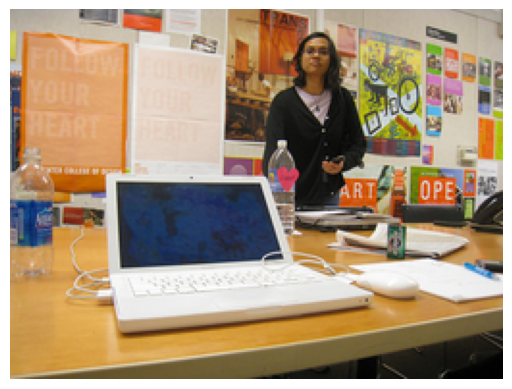

[('laptop, laptop computer', '49.9%'), ('notebook, notebook computer', '36.2%'), ('desk', '3.7%'), ('mouse, computer mouse', '0.5%'), ('space bar', '0.5%')]


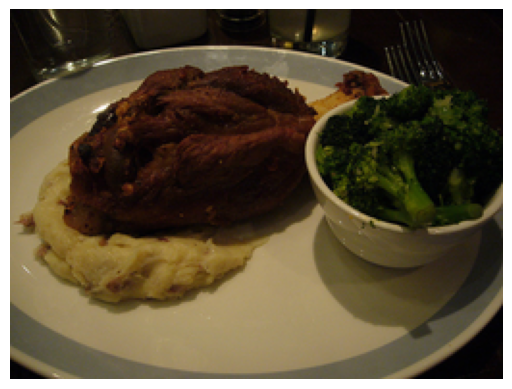

[('mashed potato', '87.0%'), ('meat loaf, meatloaf', '5.2%'), ('broccoli', '1.9%'), ('plate', '0.3%'), ('guacamole', '0.1%')]


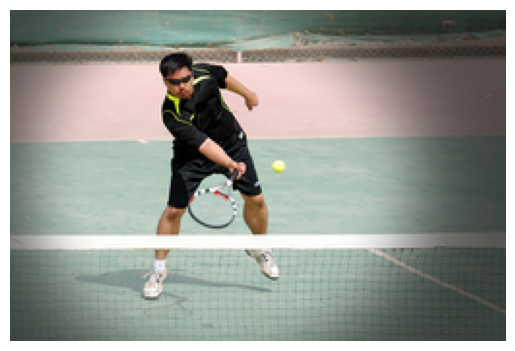

[('racket, racquet', '55.8%'), ('tennis ball', '8.4%'), ('ping-pong ball', '2.6%'), ('golf ball', '0.6%'), ('baseball', '0.6%')]


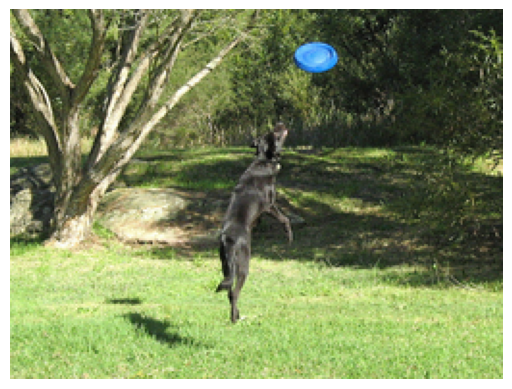

[('kelpie', '52.7%'), ('malinois', '4.1%'), ('groenendael', '3.0%'), ('schipperke', '3.0%'), ('Scottish deerhound, deerhound', '2.6%')]


In [6]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

for uri, result in zip(uris, results):
    # requests.get: 주어진 URI에서 이미지를 다운로드
    # - stream=True: 스트림을 사용해 이미지를 메모리에 로드
    # - Image.open: 이미지를 열어 PIL 객체로 변환
    img = Image.open(requests.get(uri, stream=True).raw)

    # thumbnail: 이미지 크기 조정 (256x256)
    # Resampling.LANCZOS: 고품질 리샘플링 필터 사용
    img.thumbnail((256, 256), Image.Resampling.LANCZOS)

    plt.imshow(img)
    plt.axis('off')  # 축 숨기기
    plt.show()

    print(result)